In [31]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [3]:
os.getcwd()
labels = pd.read_csv('dataset/train/labels/train.csv')

train_path = r'dataset/train/train/'
test_path = r'dataset/test/'

In [4]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [5]:
labels.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [6]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

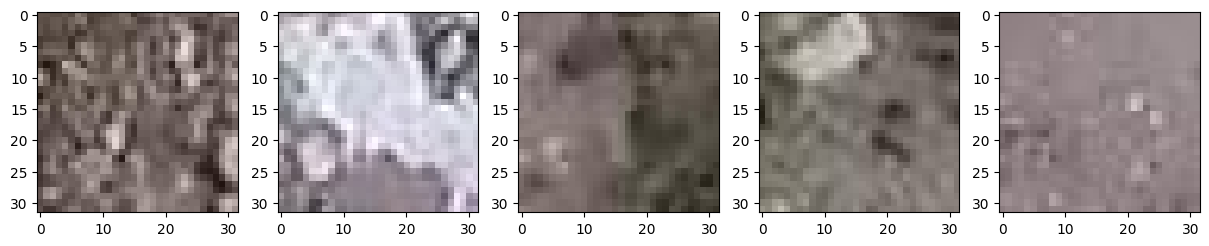

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i, idx in enumerate(labels[labels['has_cactus'] == 0]['id'][:5]):
    try:
        path = os.path.join(train_path, idx)
        ax[i].imshow(img.imread(path))
    except FileNotFoundError:
        print('File could not be found in the specified path!')

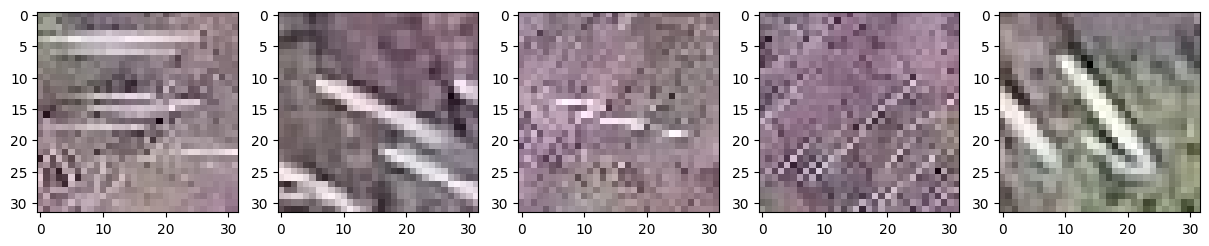

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i, idx in enumerate(labels[labels['has_cactus'] == 1]['id'][:5]):
    try:
        path = os.path.join(train_path, idx)
        ax[i].imshow(img.imread(path))
    except FileNotFoundError:
        print('File could not be found in the specified path!')

In [18]:
class AerialCactiDataset(Dataset):
    def __init__(self, data, path, transform=None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label


def calculate_mean_std(path):
    mean_sum = np.zeros(3)
    std_sum = np.zeros(3)
    num_samples = 0

    for root, dirs, files in os.walk(path):
        for file in files:
            image_path = os.path.join(root, file)
            image_rd = img.imread(image_path)
            image_rd = image_rd / 255.0

            mean_sum += np.mean(image_rd, axis=(0, 1))
            std_sum += np.std(image_rd, axis=(0, 1))
            num_samples += 1

    mean = mean_sum / num_samples
    std = std_sum / num_samples

    return mean, std

def get_transform(mean, std):
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mean,
                                                         std=std)])
    
    return transform

In [14]:
train, val_data = train_test_split(labels,
                                   stratify=labels.has_cactus,
                                   test_size=0.2)

In [20]:
train_mean, train_std = calculate_mean_std(train_path)
test_mean, test_std = calculate_mean_std(test_path)

train_transform = get_transform(train_mean, train_std)
val_transform = get_transform(train_mean, train_std)
test_transform = get_transform(test_mean, test_std)

test = pd.read_csv('dataset/sample_submission.csv')

train_data = AerialCactiDataset(train, train_path, train_transform)
val_data = AerialCactiDataset(val_data, train_path, val_transform)
test_data = AerialCactiDataset(test, test_path, test_transform)


In [32]:
# Define hyperparameters

num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.01

In [33]:
train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(dataset=val_data,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=0)

test_loader = DataLoader(dataset=test_data,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=0)

In [34]:
# Define model parameters
epochs = 50
batch_size = 30
learning_rate = 0.01

In [29]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [30]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    
    model.eval()
    for data, target in val_loader:
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item() * data.size(0)
    
    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(val_loader.sampler)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch}, Training loss: {train_loss:.6f}, Validation loss: {val_loss:.6f}')

Epoch: 0, Training loss: 0.308940, Validation loss: 0.189396
Epoch: 1, Training loss: 0.156782, Validation loss: 0.114058
Epoch: 2, Training loss: 0.125169, Validation loss: 0.087617
Epoch: 3, Training loss: 0.110864, Validation loss: 0.082011
Epoch: 4, Training loss: 0.103199, Validation loss: 0.084596
Epoch: 5, Training loss: 0.097570, Validation loss: 0.076881
Epoch: 6, Training loss: 0.092762, Validation loss: 0.075172
Epoch: 7, Training loss: 0.086977, Validation loss: 0.069801
Epoch: 8, Training loss: 0.084353, Validation loss: 0.074579
Epoch: 9, Training loss: 0.081687, Validation loss: 0.072582
Epoch: 10, Training loss: 0.077043, Validation loss: 0.091554
Epoch: 11, Training loss: 0.075966, Validation loss: 0.061684
Epoch: 12, Training loss: 0.070739, Validation loss: 0.059516
Epoch: 13, Training loss: 0.067595, Validation loss: 0.060192
Epoch: 14, Training loss: 0.065509, Validation loss: 0.060046
Epoch: 15, Training loss: 0.063003, Validation loss: 0.053942
Epoch: 16, Trainin

In [37]:
# Evaluating the model now on test data
model.eval()
with torch.inference_mode():
    correct = 0
    total = 0

    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 99.02857142857142 %


In [38]:
# Save the model
torch.save(model.state_dict(), 'model.ckpt')